In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals

import keras
from keras import utils
import tensorflow as tf
import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np


# import Tensorflow_examples.models
# tf.config.experimental.set_visible_devices([], 'GPU')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Загрузка датасета



Загрузка датасета "База домашних животных Oxford-IIITt". Включает в себя 37 категорий животных, примерно 200 изображений для каждого класса, которые различаются по масштабу, позе, освещению. Все изображения имеют аннотацию о сегментации карты (маски) на уровне пикселей: <br>
1 - Пиксель домашнего животного <br>
2 - Пиксель, граничащий с домашним животным <br>
3 - Другие, не относящиеся к 1 и 2 классу <br>

In [2]:
# python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


In [8]:
(info.splits['test'].num_examples % 16)

5

In [3]:
dataset['train']

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [4]:
dataset['test']

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

Следующий код выполнит простую аугументацию данных посредством переворота изображений. В дополнение изображение будет нормализовано к 0 и 1. Пиксели сегментационной маски будут помечены {1, 2, 3}, но для удобства из данного цифрового ряда будет вычтено по 1 и в итоге получиться {0, 1, 2}

In [5]:
def normalize(input_image, input_mask):
  img = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return img, input_mask

In [6]:
@tf.function # оптимизирует распределение графов

def load_train_ds(dataset):
  img = tf.image.resize(dataset['image'], size=(width, height))
  mask = tf.image.resize(dataset['segmentation_mask'], size=(width, height))
  
  # аугментация 
  if tf.random.uniform(()) > 0.5:
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    
  img, mask = normalize(img, mask)

  return img , mask

In [7]:
@tf.function
def load_test_ds(dataset):
  img = tf.image.resize(dataset['image'], size=(width, height))
  mask = tf.image.resize(dataset['segmentation_mask'], size=(width, height))
    
  img, mask = normalize(img, mask)

  return img , mask

Установим некоторые постоянные значения

In [8]:
# кол-во образцов в обучающем датасете
TRAIN_LENGTH = info.splits['train'].num_examples

BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# размер изображения для VGG16
width, height = 224, 224

Для сокращения времени обучения модели: <br>
### tf.data.experimental.AUTOTUNE <br>
- автоматически задаст знаечния для расчета ЦП
- распределит размер буфера

In [9]:
train = dataset['train'].map(load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_test_ds)
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)


In [10]:
for el in dataset['train']:
    print(el.keys())
    break

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])


In [11]:
train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>

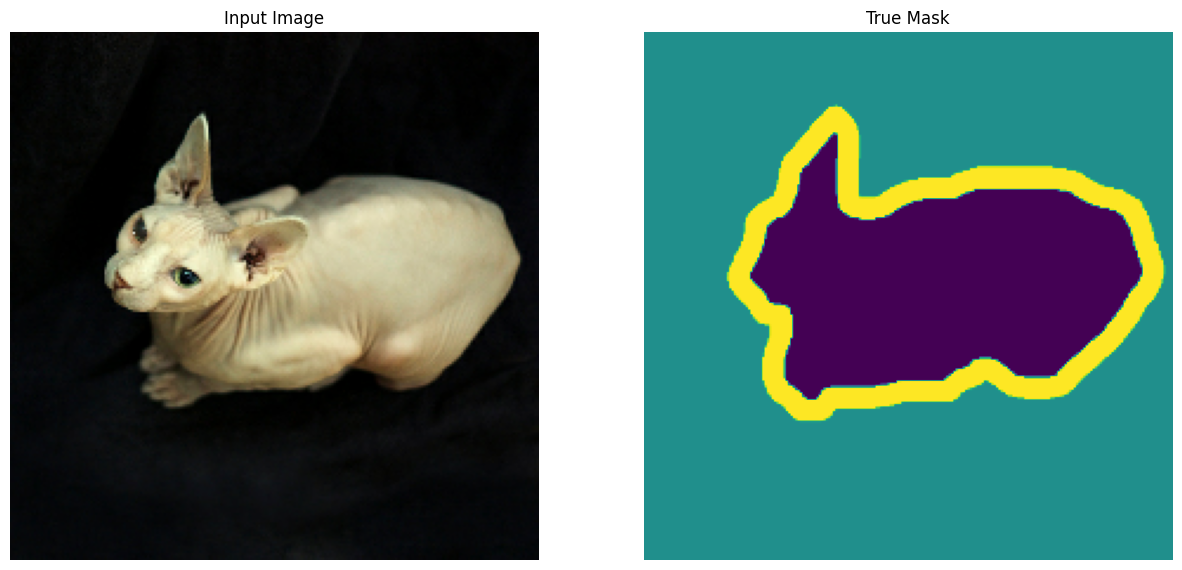

In [12]:
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(utils.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

for img, mask in train.take(1):
    sample_image, sample_mask = img, mask
    display_list = sample_image, sample_mask

display_images(display_list)

### U-Net

Энкодером будет предтренированный VGG16, который подготовлен и готов к использованию —
tf.keras.applications. Энкодер состоит из определённых аутпутов из средних слоёв модели и не будет участвовать в процессе тренировки модели.


In [13]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=(width, height, 3), include_top=False)

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
base_model.trainable = False
VGG_16 = tf.keras.models.Model(base_model.input, base_model_outputs)

![VGG16](.\image\l6_1.PNG)

Определяем декодер

In [14]:
def fcn8_decoder(convs, n_classes):
    #5 слоев после работы VGG16 
    f1, f2, f3, f4, p5 = convs
    n = 4096
    # две операции свертки с6 и с7
    c6 = tf.keras.layers.Conv2D (
        n, (7, 7), activation='relu', padding='same', 
        name='conv6')(p5)
    c7 = tf.keras.layers.Conv2D (
        n, (1, 1), activation='relu', padding='same', 
        name='conv7')(c6)

    # соединяем f5 и c7
    f5 = c7
    # транспонируем (операция обратная сверке)
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
        4, 4), strides=(2, 2), use_bias=False)(f5)
    # обрезка дополнительных пикселей
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # соединяем о2 с f4
    o2 = f4
    o2 = tf.keras.layers.Conv2D (n_classes, (1, 1),
                                 activation='relu', padding='same')(o2)

    # добавляем информацию из слоя o2 в слой o
    o = tf.keras.layers.Add()([o, o2])

    o = (tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
        4, 4), strides=(2, 2), use_bias=False)(o))
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    o2 = f3
    o2 = tf.keras.layers.Conv2D (n_classes, (1, 1),
                                 activation='relu', padding='same')(o2)
    o = tf.keras.layers.Add()([o, o2])
    o = (tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
        8, 8), strides=(8, 8), use_bias=False)(o))
    o = tf.keras.layers.Activation('softmax')(o)

    return o

In [19]:
def segmentation_model():
    inputs = keras.layers.Input(shape=(width, height, 3))
    convs = VGG_16(inputs)
    outputs = fcn8_decoder(convs , 3)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Создание маски прогнозирования

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_images([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_images([sample_image, sample_mask, 
                        create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - 1s 721ms/step


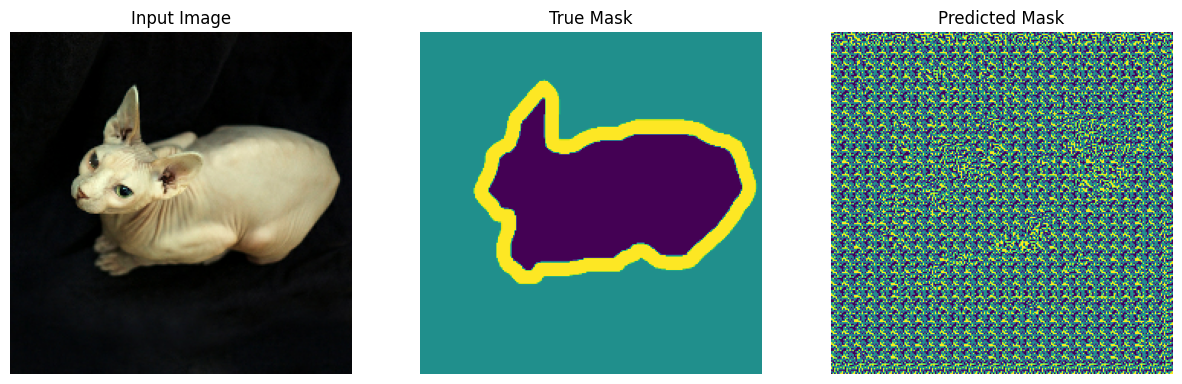

In [21]:
show_predictions()

Обучение модели

In [22]:
EPOCHS = 20
VAL_SUBSTEPS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSTEPS

model_history = model.fit(train_ds, epochs=EPOCHS,
						steps_per_epoch=STEPS_PER_EPOCH,
						validation_steps=VALIDATION_STEPS,
						validation_data=test_ds)

Epoch 1/20


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 2595s 45s/step - loss: 1.1114 - accuracy: 0.3937 - val_loss: 0.9043 - val_accuracy: 0.5373
Epoch 2/20
54/57 [===========================>..] - ETA: 2:14 - loss: 0.6134 - accuracy: 0.7327

Метрики, используемые для задач сегментации: <br>
1) IoU (Intersection-Over_union) - область перекрытия между прогнозируемой сегментацией и реальной маской, разделенная объединением двух <br>

![IoU](.\image\l6_2.PNG)

2) DiceScore - коэффициент кубика равен 2 * Площадь_перекрытия / общее кол-во пикселей
![DiceScore](.\image\l6_3.PNG)




In [ ]:
def compute_metrics(y_true, y_pred):
	'''
	Computes IOU and Dice Score.

	Args:
	y_true (tensor) - ground truth label map
	y_pred (tensor) - predicted label map
	'''

	class_wise_iou = []
	class_wise_dice_score = []

	smoothening_factor = 0.00001

	for i in range(3):
		intersection = np.sum((y_pred == i) * (y_true == i))
		y_true_area = np.sum((y_true == i))
		y_pred_area = np.sum((y_pred == i))
		combined_area = y_true_area + y_pred_area
		iou = (intersection + smoothening_factor) / \
			(combined_area - intersection + smoothening_factor)
		class_wise_iou.append(iou)

		dice_score = 2 * ((intersection + smoothening_factor) /
						(combined_area + smoothening_factor))
		class_wise_dice_score.append(dice_score)
		
	return class_wise_iou, class_wise_dice_score


In [ ]:
def get_test_image_and_annotation_arrays():
	'''
	Unpacks the test dataset and returns
	the input images and segmentation masks
	'''

	ds = test_ds.unbatch()
	ds = ds.batch(info.splits['test'].num_examples)

	images = []
	y_true_segments = []

	for image, annotation in ds.take(1):
		y_true_segments = annotation.numpy()
		images = image.numpy()

	y_true_segments = y_true_segments[:(
		info.splits['test'].num_examples - (info.splits['test']
											.num_examples % BATCH_SIZE))]
	images = images[:(info.splits['test'].num_examples -
					(info.splits['test'].num_examples % BATCH_SIZE))]

	return images, y_true_segments


y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape


def display_prediction(display_list, display_string):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask', 'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.xticks([])
		plt.yticks([])
		if i == 1:
			plt.xlabel(display_string, fontsize=12)
		plt.imshow(utils.array_to_img(display_list[i]))
	plt.show()


iou, dice_score = compute_metrics(
	y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider],
				y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(display_list[idx],
														i, dc) for idx, (i, dc) in
					enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


In [ ]:
display_prediction(display_list, display_string)

In [ ]:
OUTPUT_CHANNELS = 3
import tensorflow as tf